In [75]:
from utils import load_dataset
import matplotlib.pyplot as plt
from pathlib import Path


import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim

import torch.optim as optim

from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split


In [76]:
def train_and_evaluate_model(model, train_loader, val_loader, save_path, num_epochs=10, learning_rate=0.001):
    
    # Loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

    liste_epoch = []
    liste_train_loss = []
    liste_val_loss = []
    liste_train_acc = []
    liste_val_acc = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train

        # Validation
        model.eval()  # Evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val

        # Calculate average loss per epoch
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        # Save values for later analysis
        liste_epoch.append(epoch+1)
        liste_train_loss.append(train_loss)
        liste_val_loss.append(val_loss)
        liste_train_acc.append(train_accuracy)
        liste_val_acc.append(val_accuracy)
        
    with save_path.open('wb') as fp :
        torch.save(model,fp)

    return liste_epoch, liste_train_loss, liste_val_loss, liste_train_acc, liste_val_acc


def calculate_accuracy(model, test_loader):
    correct = 0
    total = 0

    model.eval()  # Mettre le modèle en mode d'évaluation

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Précision sur les données de test: {accuracy:.2f}%')

In [77]:
SEED = 42
torch.manual_seed(SEED)
TRAIN_RATIO = 0.8
N_CLASSES = 2

save_path = Path("Models\model_resnet18_wc.pch")

In [78]:
train_images, train_labels = load_dataset(test=False, color=False)
test_images, test_labels = load_dataset(test=True, color=False)

In [79]:
B, W, H = train_images.shape
train_images = train_images.reshape((B, 1, W, H))
train_images = np.repeat(train_images, 3, axis=1)
train_images.shape

(800, 3, 224, 224)

In [80]:
B, W, H = test_images.shape
test_images = test_images.reshape((B, 1, W, H))
test_images = np.repeat(test_images, 3, axis=1)

print(test_images.shape)

test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(200, 3, 224, 224)


In [81]:
# Diviser les données en ensembles d'entraînement et de validation
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

# Transformations

train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)

val_images = torch.tensor(val_images, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Appliquer les transformations et créer des DataLoader
train_data = TensorDataset(train_images, train_labels)
val_data = TensorDataset(val_images, val_labels)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [82]:
# Charger un modèle pré-entraîné (ResNet18)
model_resnet18 = models.resnet18(pretrained=True)

# Geler les paramètres (poids) de toutes les couches du modèle
for param in model_resnet18.parameters():
    param.requires_grad = False

# Remplacer la dernière couche de classification
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 2)  # 2 classes pour la sortie

liste_epoch, liste_train_loss, liste_val_loss, liste_train_acc, liste_val_acc = train_and_evaluate_model(model_resnet18, train_loader, val_loader, save_path = save_path, num_epochs=50, learning_rate=0.001)

Epoch 1, Train Loss: 19.5029, Val Loss: 14.5509, Train Acc: 0.6625, Val Acc: 0.8250
Epoch 2, Train Loss: 11.0116, Val Loss: 11.9796, Train Acc: 0.8828, Val Acc: 0.8063
Epoch 3, Train Loss: 7.5936, Val Loss: 9.0606, Train Acc: 0.9328, Val Acc: 0.8750
Epoch 4, Train Loss: 6.2414, Val Loss: 6.3267, Train Acc: 0.9594, Val Acc: 0.9250
Epoch 5, Train Loss: 5.8881, Val Loss: 5.0561, Train Acc: 0.9406, Val Acc: 0.9625
Epoch 6, Train Loss: 4.5945, Val Loss: 4.4287, Train Acc: 0.9734, Val Acc: 0.9688
Epoch 7, Train Loss: 4.5984, Val Loss: 4.3147, Train Acc: 0.9563, Val Acc: 0.9688
Epoch 8, Train Loss: 4.2206, Val Loss: 3.9224, Train Acc: 0.9688, Val Acc: 0.9688
Epoch 9, Train Loss: 3.5760, Val Loss: 3.9687, Train Acc: 0.9750, Val Acc: 0.9750
Epoch 10, Train Loss: 4.5323, Val Loss: 4.0874, Train Acc: 0.9594, Val Acc: 0.9688
Epoch 11, Train Loss: 3.0323, Val Loss: 3.5124, Train Acc: 0.9812, Val Acc: 0.9812
Epoch 12, Train Loss: 2.8266, Val Loss: 3.2445, Train Acc: 0.9859, Val Acc: 0.9688
Epoch 13,

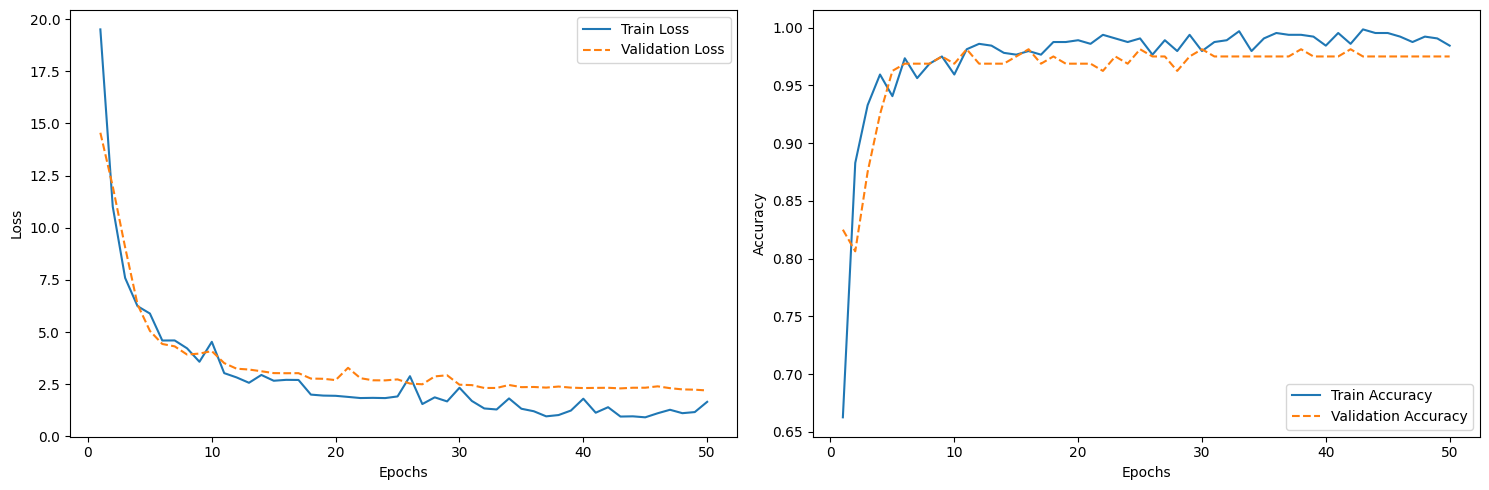

Précision sur les données de test: 98.00%


In [83]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)  # 2 rows, 1 column, this is the first subplot
plt.plot(liste_epoch, liste_train_acc, label='Train Accuracy')
plt.plot(liste_epoch, liste_val_acc, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for Loss
plt.subplot(1, 2, 1)  # 2 rows, 1 column, this is the second subplot
plt.plot(liste_epoch, liste_train_loss, label='Train Loss')
plt.plot(liste_epoch, liste_val_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


calculate_accuracy(model_resnet18, test_loader)